In [1]:
import torch
from torchvision import transforms

import os
from PIL import Image

import matplotlib.pyplot as plt

In [3]:
model = torch.hub.load('pytorch/vision:v0.6.0', 'fcn_resnet101', pretrained=True)
model.eval()

Downloading: "https://github.com/pytorch/vision/archive/v0.6.0.zip" to /home/klaas/.cache/torch/hub/v0.6.0.zip
Downloading: "https://download.pytorch.org/models/resnet101-5d3b4d8f.pth" to /home/klaas/.cache/torch/hub/checkpoints/resnet101-5d3b4d8f.pth


Downloading: "https://download.pytorch.org/models/fcn_resnet101_coco-7ecb50ca.pth" to /home/klaas/.cache/torch/hub/checkpoints/fcn_resnet101_coco-7ecb50ca.pth


FCN(
  (backbone): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequenti

In [2]:
filename = '/home/klaas/code/imitation-learning-codebase/experimental_data/line_world_real/livingroom_0/raw_data/20-07-22_18-52-52_joystick/observation/001595436796353.jpg'

In [7]:
input_image = Image.open(filename)
preprocess = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

input_tensor = preprocess(input_image)
input_batch = input_tensor.unsqueeze(0) # create a mini-batch as expected by the model

# move the input and model to GPU for speed if available
if torch.cuda.is_available():
    input_batch = input_batch.to('cuda')
    model.to('cuda')

with torch.no_grad():
    output = model(input_batch)['out'][0]
output_predictions = output.argmax(0)

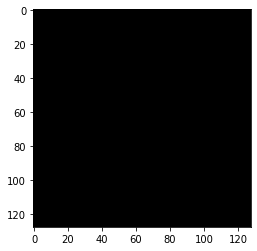

In [9]:
# create a color pallette, selecting a color for each class
palette = torch.tensor([2 ** 25 - 1, 2 ** 15 - 1, 2 ** 21 - 1])
colors = torch.as_tensor([i for i in range(21)])[:, None] * palette
colors = (colors % 255).numpy().astype("uint8")

# plot the semantic segmentation predictions of 21 classes in each color
r = Image.fromarray(output_predictions.byte().cpu().numpy()).resize(input_image.size)
r.putpalette(colors)

plt.imshow(r)
plt.show()


In [3]:
import cv2
import math
import numpy as np

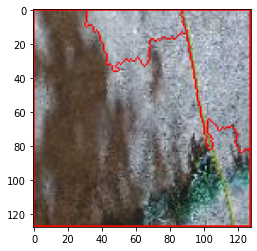

In [4]:
img = cv2.imread(filename)

gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
ret, thresh = cv2.threshold(gray,0,255,8)
# noise removal
kernel = np.ones((3,3),np.uint8)
opening = cv2.morphologyEx(thresh,cv2.MORPH_OPEN,kernel, iterations = 2)

# sure background area
sure_bg = cv2.dilate(opening,kernel,iterations=3)
# Finding sure foreground area
dist_transform = cv2.distanceTransform(opening,cv2.DIST_L2,5)
ret, sure_fg = cv2.threshold(dist_transform,0.7*dist_transform.max(),255,0)
# Finding unknown region
sure_fg = np.uint8(sure_fg)
unknown = cv2.subtract(sure_bg,sure_fg)

# Marker labelling
ret, markers = cv2.connectedComponents(sure_fg)
# Add one to all labels so that sure background is not 0, but 1
markers = markers+1
# Now, mark the region of unknown with zero
markers[unknown==255] = 0

markers = cv2.watershed(img, markers)
img[markers == -1] = [255,0,0]
plt.imshow(img)

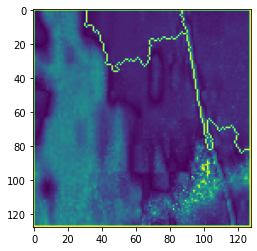

In [72]:
img_lines = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
plt.imshow(img_lines[:,:,1])

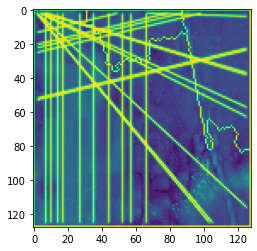

In [97]:
#img_lines = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
img_lines = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
img_lines = cv2.cvtColor(img_lines, cv2.COLOR_BGR2GRAY)

lines = cv2.HoughLinesP(img_lines, 
                        rho=100, 
                        theta=np.pi/180, 
                        threshold=10000, 
                        lines=None, 
                        minLineLength=50, 
                        maxLineGap=128)
    
if lines is not None:
    for i in range(0, len(lines)):
        rho = lines[i][0][0]
        theta = lines[i][0][1]
        a = math.cos(theta)
        b = math.sin(theta)
        x0 = a * rho
        y0 = b * rho
        pt1 = (int(x0 + 1000*(-b)), int(y0 + 1000*(a)))
        pt2 = (int(x0 - 1000*(-b)), int(y0 - 1000*(a)))
        cv2.line(img_lines, pt1, pt2, (255,0,0), 1, cv2.LINE_AA)
plt.imshow(img_lines)

<ipython-input-62-71e9cdb9cf4c>:10: FutureWarning: skimage.measure.label's indexing starts from 0. In future version it will start from 1. To disable this warning, explicitely set the `start_label` parameter to 1.
  segments = slic(img_as_float(img_superpix), n_segments=50, slic_zero=True)


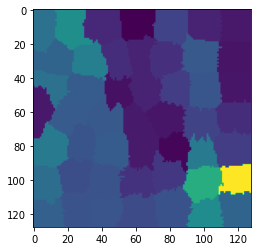

In [62]:
from skimage import img_as_float
from skimage.segmentation import slic

img = cv2.imread(filename)
img_superpix = img
result = np.zeros(img_superpix.shape[:2], dtype=np.float)
#segments = cv2.ximgproc.createSuperpixelLSC(img_as_float(img_superpix), 
#                                            region_size=10, 
#                                            ratio=0.1)
segments = slic(img_as_float(img_superpix), n_segments=50, slic_zero=True)

# loop over each of the unique superpixels
for v in np.unique(segments):
    mask = np.ones(img_superpix.shape[:2])
    mask[segments == v] = 0
    C = segment_colorfulness(img_superpix, mask)
    result[segments == v] = C
plt.imshow(result)

In [48]:
def segment_colorfulness(image, mask):
	# split the image into its respective RGB components, then mask
	# each of the individual RGB channels so we can compute
	# statistics only for the masked region
	(B, G, R) = cv2.split(image.astype("float"))
	R = np.ma.masked_array(R, mask=mask)
	G = np.ma.masked_array(B, mask=mask)
	B = np.ma.masked_array(B, mask=mask)
	# compute rg = R - G
	rg = np.absolute(R - G)
	# compute yb = 0.5 * (R + G) - B
	yb = np.absolute(0.5 * (R + G) - B)
	# compute the mean and standard deviation of both `rg` and `yb`,
	# then combine them
	stdRoot = np.sqrt((rg.std() ** 2) + (yb.std() ** 2))
	meanRoot = np.sqrt((rg.mean() ** 2) + (yb.mean() ** 2))
	# derive the "colorfulness" metric and return it
	return stdRoot + (0.3 * meanRoot)